In [1]:
# Cell 1: Environment, imports, seeds, config
import os, random, time, json
from copy import deepcopy
from collections import Counter
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
from torch.utils.data import DataLoader

from datasets import Dataset
from transformers import (AutoTokenizer, AutoModelForSequenceClassification)

from sklearn.model_selection import train_test_split
from sklearn.metrics import (accuracy_score, precision_recall_fscore_support,
                             confusion_matrix, roc_auc_score, roc_curve, classification_report)

# reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

# Config (adjust as needed)
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
MODEL_NAME = "roberta-base"
MAX_LENGTH = 256        # sequence length
BATCH_SIZE = 8
N_EPOCHS = 3
LR = 2e-5
OUTPUT_DIR = "centralized_model"
os.makedirs(OUTPUT_DIR, exist_ok=True)

DATA_CSV = "combined_healthcare_prompts_mini.csv"  # ensure this is in runtime
print("DEVICE:", DEVICE)
print("MODEL:", MODEL_NAME, "MAX_LEN:", MAX_LENGTH, "BATCH:", BATCH_SIZE)


DEVICE: cuda
MODEL: roberta-base MAX_LEN: 256 BATCH: 8


In [2]:
# Cell 2 (FIXED for your dataset): Load CSV + create `text` and `label`

df = pd.read_csv(DATA_CSV)
print("CSV columns:", df.columns.tolist())

# Fix capitalization + spacing by normalizing column names
df.columns = [c.strip().lower().replace(" ", "_") for c in df.columns]
print("Normalized columns:", df.columns.tolist())

# Now expected columns are: system_prompt, user_prompt, label

# Create text column by concatenating system + user prompts
if "system_prompt" in df.columns and "user_prompt" in df.columns:
    df["text"] = (
        df["system_prompt"].fillna("") + " " + df["user_prompt"].fillna("")
    ).str.strip()
    print("Created `text` column from system_prompt + user_prompt")
else:
    raise ValueError("Expected columns 'System Prompt' and 'User Prompt' in CSV.")

# Fix label column
if "label" in df.columns:
    df["label"] = df["label"].astype(int)
else:
    raise ValueError("Expected column 'Label' in CSV.")

print("Dataset size:", len(df))
print(df["label"].value_counts(), "\nfractions:\n", df["label"].value_counts(normalize=True))


CSV columns: ['System Prompt', 'User Prompt', 'Label']
Normalized columns: ['system_prompt', 'user_prompt', 'label']
Created `text` column from system_prompt + user_prompt
Dataset size: 7243
label
1    4294
0    2949
Name: count, dtype: int64 
fractions:
 label
1    0.592848
0    0.407152
Name: proportion, dtype: float64


In [3]:
# Cell 3: Stratified train/val/test split (80/10/10)
train_df, temp_df = train_test_split(df, test_size=0.2, stratify=df["label"], random_state=SEED)
val_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df["label"], random_state=SEED)

print("Sizes -> train, val, test:", len(train_df), len(val_df), len(test_df))
print("Label dist train/val/test:",
      train_df["label"].value_counts().to_dict(),
      val_df["label"].value_counts().to_dict(),
      test_df["label"].value_counts().to_dict())

# Convert to HF Datasets (tokenize after)
train_ds = Dataset.from_pandas(train_df.reset_index(drop=True))
val_ds   = Dataset.from_pandas(val_df.reset_index(drop=True))
test_ds  = Dataset.from_pandas(test_df.reset_index(drop=True))


Sizes -> train, val, test: 5794 724 725
Label dist train/val/test: {1: 3435, 0: 2359} {1: 429, 0: 295} {1: 430, 0: 295}


In [4]:
# Cell 4: Tokenizer + batched tokenization
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, use_fast=True)

def tokenize_fn(batch):
    return tokenizer(batch["text"], truncation=True, padding="max_length", max_length=MAX_LENGTH)

train_ds = train_ds.map(tokenize_fn, batched=True, remove_columns=[c for c in train_ds.column_names if c not in ("text","label")])
val_ds   = val_ds.map(tokenize_fn, batched=True, remove_columns=[c for c in val_ds.column_names if c not in ("text","label")])
test_ds  = test_ds.map(tokenize_fn, batched=True, remove_columns=[c for c in test_ds.column_names if c not in ("text","label")])

cols = ["input_ids", "attention_mask", "label"]
train_ds.set_format(type="torch", columns=cols)
val_ds.set_format(type="torch", columns=cols)
test_ds.set_format(type="torch", columns=cols)

print("Tokenization complete. Example features:", train_ds.features)


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Map:   0%|          | 0/5794 [00:00<?, ? examples/s]

Map:   0%|          | 0/724 [00:00<?, ? examples/s]

Map:   0%|          | 0/725 [00:00<?, ? examples/s]

Tokenization complete. Example features: {'label': Value('int64'), 'text': Value('string'), 'input_ids': List(Value('int32')), 'attention_mask': List(Value('int8'))}


In [5]:
# Cell 5: DataLoaders

from torch.utils.data import DataLoader

def collate_fn(batch):
    input_ids = torch.stack([item["input_ids"] for item in batch])
    attention_mask = torch.stack([item["attention_mask"] for item in batch])
    labels = torch.tensor([int(item["label"]) for item in batch], dtype=torch.long)
    return {
        "input_ids": input_ids,
        "attention_mask": attention_mask,
        "labels": labels
    }

train_loader = DataLoader(
    train_ds,
    batch_size=BATCH_SIZE,
    shuffle=True,
    collate_fn=collate_fn
)

val_loader = DataLoader(
    val_ds,
    batch_size=BATCH_SIZE,
    shuffle=False,
    collate_fn=collate_fn
)

test_loader = DataLoader(
    test_ds,
    batch_size=BATCH_SIZE,
    shuffle=False,
    collate_fn=collate_fn
)


In [6]:
# Cell 6: Evaluation helper
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, roc_auc_score

def evaluate_model(model, dataloader):
    model.eval()
    preds, golds, probs = [], [], []

    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch["input_ids"].to(DEVICE)
            attention_mask = batch["attention_mask"].to(DEVICE)
            labels = batch["labels"].to(DEVICE)

            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )
            logits = outputs.logits

            # predictions
            pred = torch.argmax(logits, dim=-1)
            preds.extend(pred.cpu().tolist())
            golds.extend(labels.cpu().tolist())

            # probabilities (class 1)
            prob = torch.softmax(logits, dim=-1)[:, 1]
            probs.extend(prob.cpu().tolist())

    acc = accuracy_score(golds, preds)
    prec, rec, f1, _ = precision_recall_fscore_support(
        golds, preds, average="binary", zero_division=0
    )

    try:
        auc = roc_auc_score(golds, probs)
    except ValueError:
        auc = None

    return {
        "accuracy": acc,
        "precision": prec,
        "recall": rec,
        "f1": f1,
        "auc": auc,
        "preds": preds,
        "golds": golds,
        "probs": probs
    }


In [7]:
# Cell 7: Load model & prepare optimizer, scheduler, weighted loss
model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=2).to(DEVICE)

optimizer = torch.optim.AdamW(model.parameters(), lr=LR)
total_steps = len(train_loader) * N_EPOCHS
warmup_steps = max(1, int(0.06 * total_steps))
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=warmup_steps, num_training_steps=total_steps)

# compute class weights and set criterion
train_labels = np.array([int(x) for x in train_ds["label"]])
class_sample_counts = np.bincount(train_labels)
inv_freq = len(train_labels) / (class_sample_counts + 1e-9)
class_weights = torch.tensor(inv_freq, dtype=torch.float).to(DEVICE)
criterion = torch.nn.CrossEntropyLoss(weight=class_weights)
print("Class counts:", class_sample_counts, "class_weights:", class_weights.cpu().numpy())


model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Class counts: [2359 3435] class_weights: [2.4561255 1.686754 ]


In [9]:
# Cell 8: Centralized training loop (weighted loss) + validation / checkpointing
best_val_f1 = -1.0
history = {"train_loss": [], "val_f1": []}

for epoch in range(1, N_EPOCHS + 1):
    model.train()
    running_loss = 0.0
    steps = 0
    t0 = time.time()
    for batch in train_loader:
        optimizer.zero_grad()
        input_ids = batch["input_ids"].to(DEVICE)
        attn = batch["attention_mask"].to(DEVICE)
        labels = batch["labels"].to(DEVICE)
        outputs = model(input_ids=input_ids, attention_mask=attn)
        logits = outputs.logits
        loss = criterion(logits, labels)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()
        running_loss += loss.item()
        steps += 1
    avg_train_loss = running_loss / max(1, steps)
    val_metrics = evaluate_model(model, val_loader)
    history["train_loss"].append(avg_train_loss)
    history["val_f1"].append(val_metrics["f1"])
    print(f"Epoch {epoch} done | train_loss={avg_train_loss:.4f} val_f1={val_metrics['f1']:.4f} val_acc={val_metrics['accuracy']:.4f} time={time.time()-t0:.1f}s")
    if val_metrics["f1"] > best_val_f1:
        best_val_f1 = val_metrics["f1"]
        print("New best val F1:", best_val_f1, " -> saving model")
        model.save_pretrained(OUTPUT_DIR)
        tokenizer.save_pretrained(OUTPUT_DIR)

print("Centralized training finished. Best val F1:", best_val_f1)


Epoch 1 done | train_loss=0.1281 val_f1=0.9543 val_acc=0.9475 time=285.0s
New best val F1: 0.9543269230769231  -> saving model
Epoch 2 done | train_loss=0.0965 val_f1=0.9567 val_acc=0.9489 time=285.1s
New best val F1: 0.9567251461988304  -> saving model
Epoch 3 done | train_loss=0.0690 val_f1=0.9567 val_acc=0.9489 time=285.1s
Centralized training finished. Best val F1: 0.9567251461988304


FINAL TEST METRICS
accuracy: 0.9503448275862069
precision: 0.9624413145539906
recall: 0.9534883720930233
f1: 0.9579439252336449
auc: 0.9957903035080804


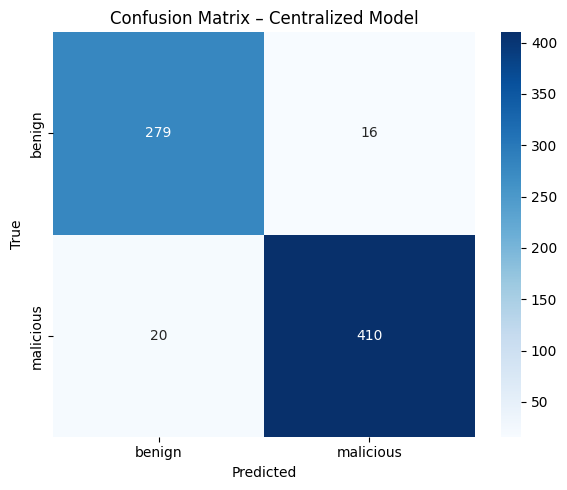

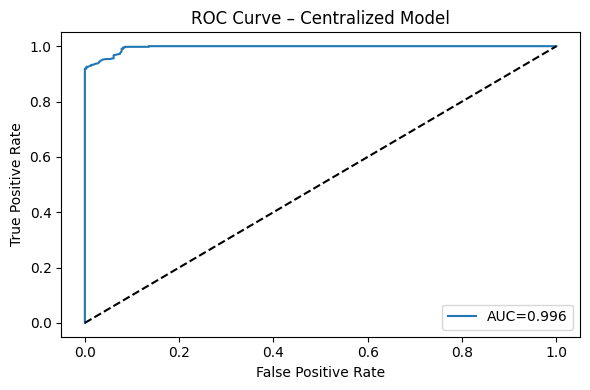

In [10]:
#cell 9 Final Evaluation: Test Metrics, Confusion Matrix, ROC

from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns

# Load best model
best_model = AutoModelForSequenceClassification.from_pretrained(OUTPUT_DIR).to(DEVICE)
best_model.eval()

# Evaluate on test data
res = evaluate_model(best_model, test_loader)

print("FINAL TEST METRICS")
for m in ["accuracy", "precision", "recall", "f1", "auc"]:
    print(f"{m}: {res[m]}")

# Confusion Matrix
cm = confusion_matrix(res["golds"], res["preds"])
labels = ["benign", "malicious"]

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix – Centralized Model")
plt.tight_layout()
plt.show()

# ROC Curve
if res["auc"] is not None:
    fpr, tpr, _ = roc_curve(res["golds"], res["probs"])
    auc_val = roc_auc_score(res["golds"], res["probs"])

    plt.figure(figsize=(6,4))
    plt.plot(fpr, tpr, label=f"AUC={auc_val:.3f}")
    plt.plot([0,1],[0,1],'k--')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve – Centralized Model")
    plt.legend()
    plt.tight_layout()
    plt.show()


In [11]:
# Cell 10: Federated split helpers (IID and Dirichlet Non-IID)
def split_iid_indices(n_samples, num_clients):
    idxs = np.arange(n_samples)
    np.random.shuffle(idxs)
    return np.array_split(idxs, num_clients)

def split_dirichlet(labels, num_clients, alpha=0.3):
    # returns list of arrays of indices for each client (dirichlet partition)
    labels = np.array(labels)
    num_classes = len(np.unique(labels))
    idx_by_class = [np.where(labels == c)[0] for c in range(num_classes)]
    client_indices = [[] for _ in range(num_clients)]
    for c, idx_c in enumerate(idx_by_class):
        proportions = np.random.dirichlet(alpha=[alpha]*num_clients)
        # make proportions sum to number of samples in class
        proportions = (np.cumsum(proportions) * len(idx_c)).astype(int)
        prev = 0
        for i, cut in enumerate(proportions):
            sel = idx_c[prev:cut]
            client_indices[i].extend(sel.tolist())
            prev = cut
    client_indices = [np.array(sorted(ci)) for ci in client_indices]
    return client_indices


In [16]:
# Cell 11: Create IID and Non-IID client DataLoaders

NUM_CLIENTS = 3 # choose >=2, keep fixed for experiments

# Create client index splits
iid_splits = split_iid_indices(len(train_ds), NUM_CLIENTS)
noniid_splits = split_dirichlet(train_ds["label"], NUM_CLIENTS, alpha=0.3)

print("IID split sizes:", [len(x) for x in iid_splits])
print("Non-IID split sizes:", [len(x) for x in noniid_splits])

from torch.utils.data import DataLoader

def make_client_loader(indices):
    subset = train_ds.select(indices.tolist())
    subset.set_format(
        type="torch",
        columns=["input_ids", "attention_mask", "label"]
    )
    return DataLoader(
        subset,
        batch_size=BATCH_SIZE,
        shuffle=True,
        collate_fn=collate_fn
    )

iid_loaders = [make_client_loader(idx) for idx in iid_splits]
noniid_loaders = [make_client_loader(idx) for idx in noniid_splits]

print("Created IID loaders:", len(iid_loaders))
print("Created Non-IID loaders:", len(noniid_loaders))


IID split sizes: [1932, 1931, 1931]
Non-IID split sizes: [2947, 686, 2161]
Created IID loaders: 3
Created Non-IID loaders: 3


In [17]:
from copy import deepcopy
import torch
from transformers import AutoModelForSequenceClassification

def run_fed_with_loaders_safe(
    loaders,
    rounds=3,
    local_epochs=1,
    device=None,
    model_name=None,
    mode="iid"
):
    """
    Federated learning with sample-weighted FedAvg.
    loaders: list of DataLoaders (one per client)
    returns: dict with history, final metrics, global model state
    """

    # ------------------ Setup ------------------
    if device is None:
        device = DEVICE if "DEVICE" in globals() else (
            "cuda" if torch.cuda.is_available() else "cpu"
        )

    if model_name is None:
        model_name = globals().get("MODEL_NAME", "roberta-base")

    print(f"\nInitializing GLOBAL model ({mode}) → {model_name} on {device}")

    global_model = AutoModelForSequenceClassification.from_pretrained(
        model_name, num_labels=2
    ).to(device)

    global_state = deepcopy(global_model.state_dict())

    history = {
        "rounds": [],
        "val_f1": [],
        "val_acc": [],
        "client_losses": []
    }

    # ------------------ Federated Rounds ------------------
    for r in range(1, rounds + 1):
        print(f"\n--- Federated Round {r}/{rounds} ({mode}) ---")

        client_states = []
        client_losses = []

        # -------- Local training on each client --------
        for cid, loader in enumerate(loaders):
            n_samples = len(loader.dataset)
            print(f" Client {cid+1}: {n_samples} samples")

            local_model = AutoModelForSequenceClassification.from_pretrained(
                model_name, num_labels=2
            )
            local_model.load_state_dict(global_state)
            local_model.to(device)
            local_model.train()

            optimizer = torch.optim.AdamW(
                local_model.parameters(),
                lr=globals().get("LR", 2e-5)
            )

            total_loss = 0.0
            steps = 0

            for _ in range(local_epochs):
                for batch in loader:
                    optimizer.zero_grad()

                    input_ids = batch["input_ids"].to(device)
                    attention_mask = batch["attention_mask"].to(device)
                    labels = batch["labels"].to(device)

                    outputs = local_model(
                        input_ids=input_ids,
                        attention_mask=attention_mask,
                        labels=labels
                    )

                    loss = outputs.loss
                    loss.backward()
                    torch.nn.utils.clip_grad_norm_(
                        local_model.parameters(), 1.0
                    )
                    optimizer.step()

                    total_loss += loss.item()
                    steps += 1

            avg_loss = total_loss / max(steps, 1)
            print(f"  → Client {cid+1} avg loss: {avg_loss:.4f}")

            client_losses.append(avg_loss)
            client_states.append({
                k: v.cpu() for k, v in local_model.state_dict().items()
            })

        # -------- CORRECT FedAvg (sample-weighted) --------
        total_samples = sum(len(loader.dataset) for loader in loaders)

        new_global_state = {}
        for k in global_state.keys():
            new_global_state[k] = sum(
                (len(loaders[i].dataset) / total_samples)
                * client_states[i][k].float()
                for i in range(len(client_states))
            )

        global_state = new_global_state
        global_model.load_state_dict(global_state)

        # -------- Validation (simulation setting) --------
        if "val_loader" in globals():
            val_metrics = evaluate_model(
                global_model.to(device), val_loader
            )
            print(
                f" Round {r} validation → "
                f"F1={val_metrics['f1']:.4f}, "
                f"Acc={val_metrics['accuracy']:.4f}"
            )

            history["val_f1"].append(val_metrics["f1"])
            history["val_acc"].append(val_metrics["accuracy"])
        else:
            history["val_f1"].append(None)
            history["val_acc"].append(None)

        history["client_losses"].append(client_losses)
        history["rounds"].append(r)

    # ------------------ Final Test Evaluation ------------------
    final_metrics = None
    if "test_loader" in globals():
        final_metrics = evaluate_model(
            global_model.to(device), test_loader
        )
        print("\nFINAL FEDERATED TEST METRICS:")
        for k, v in final_metrics.items():
            if k not in ["preds", "golds", "probs"]:
                print(f" {k}: {v}")
    else:
        print("No test_loader found → skipping test evaluation")

    return {
        "history": history,
        "final_metrics": final_metrics,
        "global_model_state": global_state
    }


In [18]:
ROUNDS = 4        # or 3, 5 — your choice
LOCAL_EPOCHS = 3    # number of epochs each client trains locally



In [19]:
res_iid = run_fed_with_loaders_safe(iid_loaders, rounds=ROUNDS, local_epochs=LOCAL_EPOCHS)
res_non = run_fed_with_loaders_safe(noniid_loaders, rounds=ROUNDS, local_epochs=LOCAL_EPOCHS)


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Initializing GLOBAL model (iid) → roberta-base on cuda


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



--- Federated Round 1/4 (iid) ---
 Client 1: 1932 samples
  → Client 1 avg loss: 0.2285


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


 Client 2: 1931 samples
  → Client 2 avg loss: 0.2131


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


 Client 3: 1931 samples
  → Client 3 avg loss: 0.2158
 Round 1 validation → F1=0.9590, Acc=0.9503

--- Federated Round 2/4 (iid) ---
 Client 1: 1932 samples


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  → Client 1 avg loss: 0.1369
 Client 2: 1931 samples


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  → Client 2 avg loss: 0.1214
 Client 3: 1931 samples


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  → Client 3 avg loss: 0.1348


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


 Round 2 validation → F1=0.9588, Acc=0.9503

--- Federated Round 3/4 (iid) ---
 Client 1: 1932 samples
  → Client 1 avg loss: 0.1151
 Client 2: 1931 samples


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  → Client 2 avg loss: 0.1060
 Client 3: 1931 samples


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  → Client 3 avg loss: 0.1198


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


 Round 3 validation → F1=0.9544, Acc=0.9461

--- Federated Round 4/4 (iid) ---
 Client 1: 1932 samples
  → Client 1 avg loss: 0.0801
 Client 2: 1931 samples


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  → Client 2 avg loss: 0.1009
 Client 3: 1931 samples


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  → Client 3 avg loss: 0.0971
 Round 4 validation → F1=0.9575, Acc=0.9489


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



FINAL FEDERATED TEST METRICS:
 accuracy: 0.9558620689655173
 precision: 0.954337899543379
 recall: 0.9720930232558139
 f1: 0.9631336405529954
 auc: 0.9953803705163579

Initializing GLOBAL model (iid) → roberta-base on cuda


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



--- Federated Round 1/4 (iid) ---
 Client 1: 2947 samples
  → Client 1 avg loss: 0.2097
 Client 2: 686 samples


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  → Client 2 avg loss: 0.1475
 Client 3: 2161 samples


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  → Client 3 avg loss: 0.1797


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


 Round 1 validation → F1=0.9555, Acc=0.9461

--- Federated Round 2/4 (iid) ---
 Client 1: 2947 samples
  → Client 1 avg loss: 0.1290
 Client 2: 686 samples


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  → Client 2 avg loss: 0.0522
 Client 3: 2161 samples


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  → Client 3 avg loss: 0.1049
 Round 2 validation → F1=0.9647, Acc=0.9572

--- Federated Round 3/4 (iid) ---
 Client 1: 2947 samples


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  → Client 1 avg loss: 0.1072
 Client 2: 686 samples


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  → Client 2 avg loss: 0.0579
 Client 3: 2161 samples


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  → Client 3 avg loss: 0.0859


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


 Round 3 validation → F1=0.9645, Acc=0.9572

--- Federated Round 4/4 (iid) ---
 Client 1: 2947 samples
  → Client 1 avg loss: 0.1028
 Client 2: 686 samples


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  → Client 2 avg loss: 0.0368
 Client 3: 2161 samples


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  → Client 3 avg loss: 0.0788
 Round 4 validation → F1=0.9617, Acc=0.9530

FINAL FEDERATED TEST METRICS:
 accuracy: 0.96
 precision: 0.9406593406593406
 recall: 0.9953488372093023
 f1: 0.9672316384180791
 auc: 0.9872684272763106


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


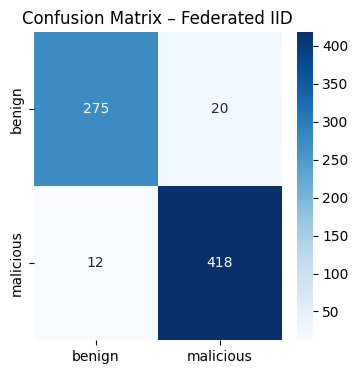

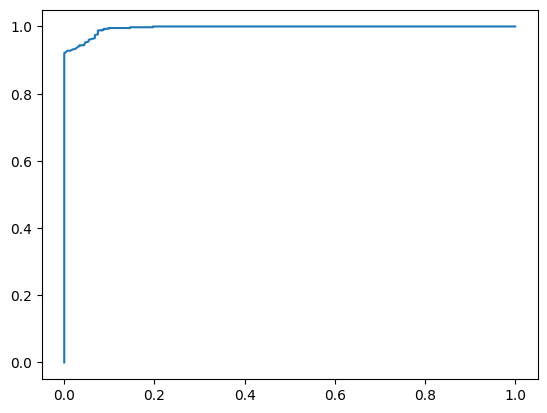

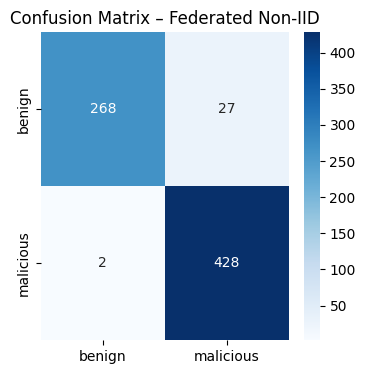

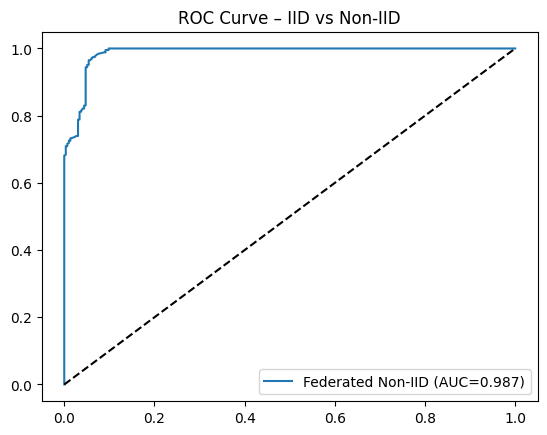

In [20]:
# Final Federated Evaluation: Confusion Matrix & ROC

from sklearn.metrics import confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns

def plot_eval(label, model):
    res = evaluate_model(model, test_loader)

    cm = confusion_matrix(res["golds"], res["preds"])
    plt.figure(figsize=(4,4))
    sns.heatmap(cm, annot=True, fmt="d",
                xticklabels=["benign","malicious"],
                yticklabels=["benign","malicious"],
                cmap="Blues")
    plt.title(f"Confusion Matrix – {label}")
    plt.show()

    fpr, tpr, _ = roc_curve(res["golds"], res["probs"])
    plt.plot(fpr, tpr, label=f"{label} (AUC={res['auc']:.3f})")

# Build models from returned global state
def build_model_from_state(state):
    m = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=2)
    m.load_state_dict(state)
    m.to(DEVICE); m.eval()
    return m

model_iid = build_model_from_state(res_iid["global_model_state"])
model_non = build_model_from_state(res_non["global_model_state"])

plot_eval("Federated IID", model_iid)
plot_eval("Federated Non-IID", model_non)

plt.plot([0,1],[0,1],'k--')
plt.title("ROC Curve – IID vs Non-IID")
plt.legend(); plt.show()


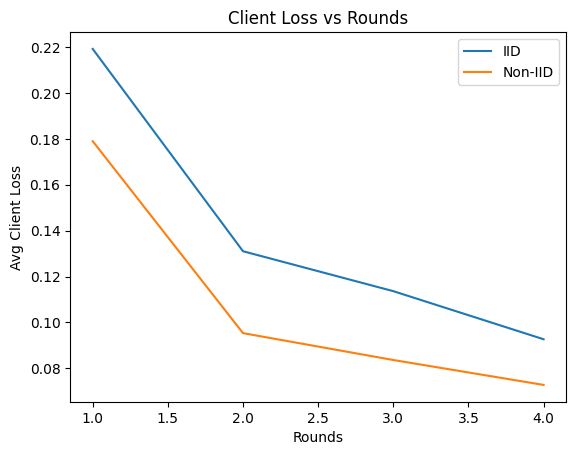

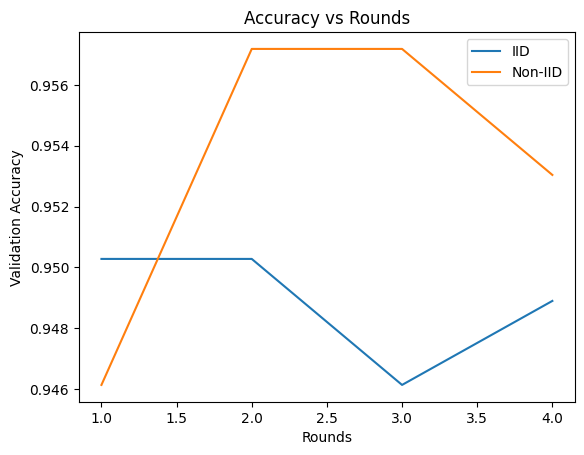

In [21]:
import numpy as np
import matplotlib.pyplot as plt

def avg_client_loss(hist):
    return [np.mean(r) for r in hist["client_losses"]]

plt.plot(res_iid["history"]["rounds"], avg_client_loss(res_iid["history"]), label="IID")
plt.plot(res_non["history"]["rounds"], avg_client_loss(res_non["history"]), label="Non-IID")
plt.xlabel("Rounds"); plt.ylabel("Avg Client Loss")
plt.title("Client Loss vs Rounds"); plt.legend(); plt.show()

plt.plot(res_iid["history"]["rounds"], res_iid["history"]["val_acc"], label="IID")
plt.plot(res_non["history"]["rounds"], res_non["history"]["val_acc"], label="Non-IID")
plt.xlabel("Rounds"); plt.ylabel("Validation Accuracy")
plt.title("Accuracy vs Rounds"); plt.legend(); plt.show()
